# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import json
import sys
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
def calc_features(url, html_data):
    
    words = list(html2word(html_data))
    words_num = len(words)
    
    avg_word_len = sum(map(len, words)) * 1.0
    if len(words) > 0:
        avg_word_len /= len(words)
    
    data = json.dumps(''.join(words))
    compression_level = 100.0 * sys.getsizeof(zlib.compress(data)) / sys.getsizeof(data)
       
    max_word_len = max(map(len, words)) * 1.0
    
    return [len(words), avg_word_len, compression_level, max_word_len]

In [11]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features

[6, 3.5, 68.0, 9.0]


In [27]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            #features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, html_data)            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [28]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

11:10:04 INFO:Complete items 00000
11:10:05 INFO:Complete items 01000
11:10:06 INFO:Complete items 02000
11:10:07 INFO:Complete items 03000
11:10:07 INFO:Complete items 04000
11:10:08 INFO:Complete items 05000
11:10:09 INFO:Complete items 06000
11:10:10 INFO:Complete items 07000
11:10:10 INFO:Complete items 07043


CPU times: user 5.26 s, sys: 208 ms, total: 5.47 s
Wall time: 5.47 s


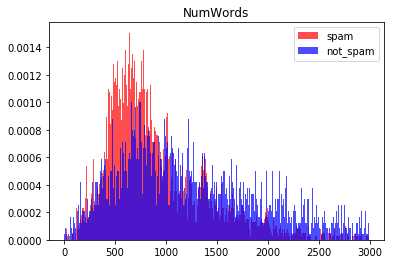

In [14]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

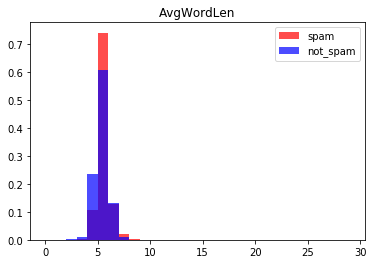

In [15]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = range(0,30,1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

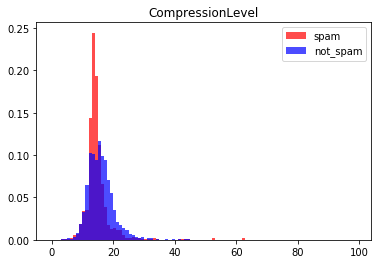

In [16]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0,100,1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompressionLevel')
plt.legend()
plt.show()

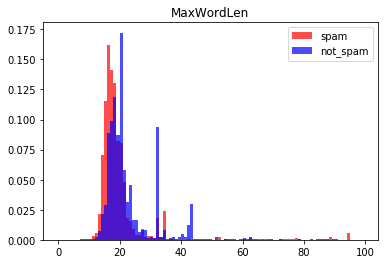

In [17]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('MaxWordLen')
plt.legend()
plt.show()

In [18]:
train_docs

[DocItem(doc_id=-9222401963271173253, is_spam=False, url='http://lawleader.ru/docs/32/', features=[3359, 6.318547186662697, 9.450029364010087, 20.0]),
 DocItem(doc_id=-9221399504663603656, is_spam=False, url='http://alterhost.ruwww.alterhost.ruwww.user.kz.ru/', features=[954, 4.915094339622642, 19.9407223600772, 16.0]),
 DocItem(doc_id=-9219733223042265364, is_spam=False, url='http://www.ferio.ru/c_1-acura-legend.html', features=[1551, 4.8807221147646676, 13.377998703263454, 21.0]),
 DocItem(doc_id=-9218561774155397294, is_spam=False, url='http://fshops.otzyv.ru/read.php?id=277', features=[1062, 4.869114877589454, 16.055916125811283, 17.0]),
 DocItem(doc_id=-9216163564171210203, is_spam=True, url='http://penhea895.narod.ru/familiya-shushmarchenko.html', features=[522, 5.241379310344827, 15.779246016323357, 15.0]),
 DocItem(doc_id=-9213263092469495632, is_spam=True, url='http://ntklhjdawv5.edu.ms/5/open24-ru-znakomstva-97.html', features=[959, 5.552659019812305, 13.48649010165864, 23.0]

** Классификатор: **
Нужно реализовать

In [19]:
from sklearn.linear_model import SGDClassifier

class Classifier:
    
    def __init__(self):
        self.clf = SGDClassifier()

    def predict(self, doc):        
        return self.clf.predict([doc.features])[0]
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def predict_all2(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( prediction)
        return res
    
    def train(self, docs):                
        X = map(lambda doc: doc.features, docs)
        Y = map(lambda doc: 1 if doc.is_spam else 0, docs)
        self.clf.fit(X, Y)

In [20]:
classifier = Classifier()
classifier.train(train_docs)

/home/timur/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [67]:
X = map(lambda doc: doc.features, train_docs)
Y = map(lambda doc: 1 if doc.is_spam else 0, train_docs)
clf = GradientBoostingClassifier()
clf.fit(X, Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [78]:
clf.predict([test_features])[0]

1

In [21]:
classifier.predict(DocItem(0, 0, test_url, test_features))

1

In [22]:
classifier.predict_all([DocItem(0, 0, test_url, test_features)])

10:50:11 INFO:Complete items 00000


[(0, 0, 'http://ololo', 1)]

** Рисуем графики **

In [ ]:
plot_results(classifier.predict_all(train_docs), min_threshold=0, max_threshold=7000, step=100, trace=1)

In [29]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'
test_docs = list(load_csv(TEST_DATA_FILE, calc_features))

11:10:16 INFO:Complete items 00000
11:10:17 INFO:Complete items 01000
11:10:18 INFO:Complete items 02000
11:10:19 INFO:Complete items 03000
11:10:19 INFO:Complete items 04000
11:10:20 INFO:Complete items 05000
11:10:21 INFO:Complete items 06000
11:10:22 INFO:Complete items 07000
11:10:23 INFO:Complete items 08000
11:10:23 INFO:Complete items 09000
11:10:24 INFO:Complete items 10000
11:10:25 INFO:Complete items 11000
11:10:26 INFO:Complete items 12000
11:10:26 INFO:Complete items 13000
11:10:27 INFO:Complete items 14000
11:10:28 INFO:Complete items 15000
11:10:29 INFO:Complete items 16000
11:10:29 INFO:Complete items 16038


In [24]:
with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[3]])

10:57:35 INFO:Complete items 00000
10:57:35 INFO:Complete items 01000
10:57:35 INFO:Complete items 02000
10:57:35 INFO:Complete items 03000
10:57:35 INFO:Complete items 04000
10:57:35 INFO:Complete items 05000
10:57:35 INFO:Complete items 06000
10:57:35 INFO:Complete items 07000
10:57:35 INFO:Complete items 08000
10:57:35 INFO:Complete items 09000
10:57:35 INFO:Complete items 10000
10:57:36 INFO:Complete items 11000
10:57:36 INFO:Complete items 12000
10:57:36 INFO:Complete items 13000
10:57:36 INFO:Complete items 14000
10:57:36 INFO:Complete items 15000
10:57:36 INFO:Complete items 16000


In [ ]:
#https://habr.com/post/264339/
#https://habr.com/post/266025/

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier

class ClassifierSGD:    
    def __init__(self):
        self.clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier())])

    def features(self, doc):        
        return doc.features
    
    def predict_all(self, docs):
        fdocs = map(self.features, docs)
        predictions = self.clf.predict(fdocs)
        return zip(map(lambda doc: doc.doc_id, docs), predictions)
    
    def train(self, docs):
        X = map(lambda doc: doc.features, docs)
        Y = map(lambda doc: 1 if doc.is_spam else 0, docs)
        self.clf.fit(X, Y)
        

In [31]:
classifier = ClassifierSGD()
classifier.train(train_docs)

In [32]:
with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        writer.writerow([item[0], item[1]])